In [ ]:
!pip install --upgrade pip
!pip install tomotopy
!pip install nltk
!pip install pyvis

In [ ]:
'''
This example shows how to perform a Correlated Topic Model using tomotopy 
and visualize the correlation between topics.


Required Packages:
    nltk, sklearn, pyvis
'''

import pandas as pd
import tomotopy as tp
import nltk
from nltk.corpus import stopwords
import re
from pyvis.network import Network

nltk.download('stopwords')

In [10]:
def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele
 
    return str1

In [16]:
#%pprint
#stopwords.words('english')

In [11]:
try:
    corpus = tp.utils.Corpus.load('preprocessed_data_total_longest_10000.cps')
except IOError:
    porter_stemmer = nltk.PorterStemmer().stem
    english_stops = set(porter_stemmer(w) for w in stopwords.words('english'))
    pat = re.compile('^[a-z]{2,}$')
    corpus = tp.utils.Corpus(
        tokenizer=tp.utils.SimpleTokenizer(porter_stemmer), 
        stopwords=lambda x: x in english_stops or not pat.match(x)
    )

    data = pd.read_csv('data_total_longest_10000.csv')
    data = data.dropna()
    data = data.drop_duplicates()
    data = data.values.tolist()
    for d in range(len(data)):
        data[d] = listToString(data[d])
    
    corpus.process(d.lower() for d in data)
    corpus.save('preprocessed_data_total_longest_10000.cps')

In [18]:
len(corpus)

18467

In [19]:
mdl = tp.CTModel(tw=tp.TermWeight.IDF, min_df=5, rm_top=40, k=39, corpus=corpus)
mdl.train(0)

# Since we have more than ten thousand of documents, 
# setting the `num_beta_sample` smaller value will not cause an inaccurate result.
mdl.num_beta_sample = 5
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(mdl.docs), len(mdl.used_vocabs), mdl.num_words
))
print('Removed Top words: ', *mdl.removed_top_words)

Num docs:18461, Num Vocabs:22651, Total Words:8456995
Removed Top words:  peopl like get would use one studi make think time also thing year even say go know work gt need much could way http differ good see take realli mean still well effect actual lot mani want articl vaccin us


In [ ]:
# Let's train the model
for i in range(0, 1000, 20):
    print('Iteration: {:04}, LL per word: {:.4}'.format(i, mdl.ll_per_word))
    mdl.train(20)
print('Iteration: {:04}, LL per word: {:.4}'.format(1000, mdl.ll_per_word))

mdl.summary()

In [13]:
# Let's visualize the result
g = Network(width=800, height=800, font_color="#333")
correl = mdl.get_correlations().reshape([-1])
correl.sort()
top_tenth = mdl.k * (mdl.k - 1) // 10
top_tenth = correl[-mdl.k - top_tenth]

for k in range(mdl.k):
    label = "#{}".format(k)
    title= ' '.join(word for word, _ in mdl.get_topic_words(k, top_n=6))
    print('Topic', label, title)
    g.add_node(k, label=label, title=title, shape='ellipse')
    for l, correlation in zip(range(k - 1), mdl.get_correlations(k)):
        if correlation < top_tenth: continue
        g.add_edge(k, l, value=float(correlation), title='{:.02}'.format(correlation))

g.barnes_hut(gravity=-1000, spring_length=20)
g.show_buttons()
g.show("topic_network.html", notebook=False)
#g.save_graph("graph_k_34.html")

Topic #0 climat earth heat chang space planet
Topic #1 human anim speci tree bacteria natur
Topic #2 fish histori eye select open interact
Topic #3 energi power fuel electr materi effici
Topic #4 black matter light small field particl
Topic #5 expect omicron wikipedia en inform look
Topic #6 edit explain seem word interest strain
Topic #7 plant plastic cost emiss water chemic
Topic #8 farm day land hous burn hydrogen
Topic #9 pain friend sick religion hear minut
Topic #10 trust argu life situat sub side
Topic #11 theori someth conspiraci thank trauma though
Topic #12 car air citi trump pollut live
Topic #13 covid women men sex white dose
Topic #14 gun money tax law pay crime
Topic #15 smoke mask addict wear walk feel
Topic #16 game compani video metal valu phone
Topic #17 point sure convers absolut claim simpl
Topic #18 meat vote right republican parti democrat
Topic #19 eat food diet drink alcohol fat
Topic #20 smell buy decis never back realiti
Topic #21 kid children parent school ca

In [11]:
mdl.save('data_total_longest_10000_k_39.bin')

# Coherence

In [3]:
import itertools

In [12]:
mdl = tp.CTModel.load('data_total_longest_10000_k_34.bin')

In [6]:
""""for preset in ('u_mass', 'c_npmi', 'c_uci', 'c_v'):    
    coh = tp.coherence.Coherence(mdl, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()"""

coh = tp.coherence.Coherence(mdl, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5138683090374495 
Per Topic: [0.4557410955429077, 0.5573164314031601, 0.7899936348199844, 0.2900616988539696, 0.5697133272886277, 0.6406625479459762, 0.34591458886861803, 0.4612594678997993, 0.38297843039035795, 0.6671221494674683, 0.46978942304849625, 0.30915950834751127, 0.7210777103900909, 0.49195572137832644, 0.4605027029290795, 0.38806458115577697, 0.4169350653886795, 0.4276274383068085, 0.4570758372545242, 0.7717777758836746, 0.5547076046466828, 0.6590748131275177, 0.5761147528886795, 0.4682131096720695]



# Visualization

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import numpy as np

In [9]:
topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0,
    sort_topics=False
)
pyLDAvis.save_html(prepared_data, 'ctmvis_k_30.html')

# 

In [3]:
import matplotlib.pyplot as plt

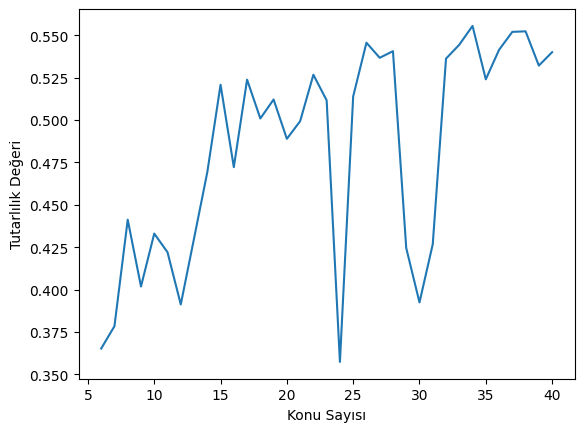

In [7]:
x = list(range(6,41))
y = [0.3652, 0.3784, 0.4412, 0.4018, 0.433, 0.422, 0.3912, 0.4301, 0.4692, 0.5208, 0.4722, 0.5238, 0.5009, 0.5121, 0.4889, 0.4993, 0.5267, 0.5116, 0.3573, 0.5139, 0.5456, 0.5367, 0.5406, 0.4245, 0.3924, 0.4267, 0.5362, 0.5444, 0.5555, 0.524, 0.5414, 0.552, 0.5523, 0.5321, 0.54]

plt.plot(x, y)
plt.xlabel("Konu Sayısı")
plt.ylabel("Tutarlılık Değeri")
plt.show()
#plt.savefig("coh.png")

In [10]:
mdl.get_correlations()   # 34

array([[ 1.        ,  0.39250466,  0.369945  , ...,  0.1254282 ,
         0.26493597,  0.18063416],
       [ 0.39250466,  1.        ,  0.45874897, ...,  0.11432437,
         0.2988579 ,  0.24452068],
       [ 0.369945  ,  0.45874897,  1.        , ...,  0.17858465,
         0.30088088,  0.24429063],
       ...,
       [ 0.1254282 ,  0.11432437,  0.17858465, ...,  1.        ,
        -0.06506519, -0.18278117],
       [ 0.26493597,  0.2988579 ,  0.30088088, ..., -0.06506519,
         1.        ,  0.2720926 ],
       [ 0.18063416,  0.24452068,  0.24429063, ..., -0.18278117,
         0.2720926 ,  1.        ]], dtype=float32)

In [9]:
new_corr = []
for i in range(len(mdl.get_correlations())):
    my_formatted_list = [ '%.2f' % elem for elem in mdl.get_correlations()[i] ]
    new_corr.append(my_formatted_list)

In [ ]:
new_corr

In [11]:
df = pd.DataFrame(new_corr)
df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.00,0.39,0.37,0.40,0.38,0.36,0.37,0.37,0.39,0.33,...,0.19,0.26,0.27,0.26,0.15,0.30,0.26,0.13,0.26,0.18
1,0.39,1.00,0.46,0.43,0.43,0.44,0.44,0.41,0.44,0.38,...,0.26,0.29,0.34,0.34,0.25,0.39,0.34,0.11,0.30,0.24
2,0.37,0.46,1.00,0.45,0.47,0.49,0.49,0.42,0.46,0.44,...,0.33,0.34,0.39,0.39,0.30,0.42,0.40,0.18,0.30,0.24
3,0.40,0.43,0.45,1.00,0.46,0.46,0.46,0.44,0.46,0.42,...,0.29,0.34,0.37,0.34,0.25,0.37,0.34,0.16,0.30,0.22
4,0.38,0.43,0.47,0.46,1.00,0.48,0.49,0.43,0.47,0.45,...,0.32,0.35,0.38,0.36,0.27,0.39,0.38,0.16,0.30,0.24
5,0.36,0.44,0.49,0.46,0.48,1.00,0.52,0.44,0.47,0.47,...,0.34,0.39,0.42,0.39,0.32,0.41,0.43,0.19,0.28,0.24
6,0.37,0.44,0.49,0.46,0.49,0.52,1.00,0.43,0.48,0.48,...,0.37,0.39,0.42,0.40,0.32,0.42,0.43,0.20,0.29,0.23
7,0.37,0.41,0.42,0.44,0.43,0.44,0.43,1.00,0.46,0.41,...,0.32,0.33,0.34,0.35,0.28,0.39,0.34,0.17,0.26,0.19
8,0.39,0.44,0.46,0.46,0.47,0.47,0.48,0.46,1.00,0.46,...,0.33,0.38,0.37,0.37,0.27,0.39,0.35,0.17,0.27,0.20
9,0.33,0.38,0.44,0.42,0.45,0.47,0.48,0.41,0.46,1.00,...,0.36,0.41,0.39,0.35,0.29,0.37,0.36,0.19,0.25,0.18


In [12]:
df.to_excel('corr_34.xlsx', index=True)